In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv("/content/MERGED.csv")
data.head()

,SEQN,RIDAGEYR,RIAGENDR,BMXWT,BMXHT,BMXWAIST,BMXBMI,BPXOSY1,BPXOSY2,BPXOSY3,...,BPXODI2,BPXODI3,BPXOPLS1,BPXOPLS2,BPXOPLS3,DIQ010,LBXGLU,LBDHDD,LBXTLG,METS_IR
0,130378.0,43.0,1.0,86.9,179.5,98.3,27.0,135.0,131.0,132.0,...,96.0,94.0,82.0,79.0,82.0,2.0,113.0,45.0,153.0,42.113919
1,130379.0,66.0,1.0,101.8,174.2,114.7,33.5,121.0,117.0,113.0,...,76.0,76.0,72.0,71.0,73.0,2.0,99.0,60.0,86.0,46.220008
2,130386.0,34.0,1.0,90.6,173.3,106.1,30.2,110.0,120.0,115.0,...,74.0,75.0,59.0,64.0,64.0,2.0,100.0,46.0,142.0,46.024494
3,130394.0,51.0,1.0,76.7,177.3,92.1,24.4,99.0,110.0,123.0,...,68.0,67.0,78.0,82.0,79.0,2.0,88.0,48.0,57.0,34.357642
4,130396.0,56.0,2.0,65.6,154.9,97.9,27.3,122.0,128.0,120.0,...,81.0,82.0,63.0,68.0,67.0,2.0,104.0,68.0,108.0,37.239359


In [ ]:
def compute_map(df):
    """
    Compute Mean Arterial Pressure (MAP) from NHANES BP readings
    similar to a home BP device and drop raw SBP/DBP readings.
    """
    # Compute average SBP and DBP from 2nd and 3rd readings
    sbp_avg = df[['BPXOSY2', 'BPXOSY3']].mean(axis=1)
    dbp_avg = df[['BPXODI2', 'BPXODI3']].mean(axis=1)

    # Compute MAP
    df['MAP'] = dbp_avg + (sbp_avg - dbp_avg) / 3

    # Drop raw BP and pulse readings
    drop_cols = [
        'BPXOSY1', 'BPXOSY2', 'BPXOSY3',
        'BPXODI1', 'BPXODI2', 'BPXODI3',
        'BPXOPLS1', 'BPXOPLS2', 'BPXOPLS3'
    ]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])

    return df

# Usage
data = compute_map(data)


In [ ]:
# Mapping of NHANES columns to readable names
rename_dict = {
    'SEQN': 'ParticipantID',
    'RIDAGEYR': 'Age',
    'RIAGENDR': 'Gender',
    'BMXWT': 'Weight_kg',
    'BMXHT': 'Height_cm',
    'BMXWAIST': 'Waist_cm',
    'BMXBMI': 'BMI',
    'DIQ010': 'Has_Diabetes',
    'LBXGLU': 'Fasting_Glucose_mg_dL',
    'LBDHDD': 'HDL_mg_dL',
    'LBXTLG': 'Triglycerides_mg_dL',
    'METS_IR': 'METS_IR',
    'MAP': 'MAP'
}

# Apply renaming
data = data.rename(columns=rename_dict)

# Check the result
data.columns

Index(['ParticipantID', 'Age', 'Gender', 'Weight_kg', 'Height_cm', 'Waist_cm',
       'BMI', 'Has_Diabetes', 'Fasting_Glucose_mg_dL', 'HDL_mg_dL',
       'Triglycerides_mg_dL', 'METS_IR', 'MAP'],
      dtype='object')

In [ ]:
def compute_bmi(df):
    # -------------------------
    # 1️⃣ Compute BMI and drop Weight & Height
    # -------------------------
    # Height in cm → convert to meters
    df['Height_m'] = df['Height_cm'] / 100

    # BMI = weight (kg) / height (m)^2
    df['BMI'] = df['Weight_kg'] / (df['Height_m'] ** 2)

    # Drop original weight and height columns
    df = df.drop(columns=['Weight_kg', 'Height_cm', 'Height_m'])

    # Check new dataframe
    return df
# Usage
data = compute_bmi(data)


In [ ]:
data.head()

,ParticipantID,Age,Gender,Waist_cm,BMI,Has_Diabetes,Fasting_Glucose_mg_dL,HDL_mg_dL,Triglycerides_mg_dL,METS_IR,MAP
0,130378.0,43.0,1.0,98.3,26.970616,2.0,113.0,45.0,153.0,42.113919,107.166667
1,130379.0,66.0,1.0,114.7,33.546829,2.0,99.0,60.0,86.0,46.220008,89.000000
2,130386.0,34.0,1.0,106.1,30.166927,2.0,100.0,46.0,142.0,46.024494,88.833333
3,130394.0,51.0,1.0,92.1,24.399330,2.0,88.0,48.0,57.0,34.357642,83.833333
4,130396.0,56.0,2.0,97.9,27.340157,2.0,104.0,68.0,108.0,37.239359,95.666667


In [ ]:
# Columns a home user can provide
home_features = [
    'Age',          # RIDAGEYR
    'Gender',       # RIAGENDR
    "BMI",          # BMI = weigth / heigth ^ 2
    'Waist_cm',     # BMXWAIST
    'METS_IR',      # derived from lab values
    'MAP'           # derived from BP
]

# Keep only existing columns (in case some are missing)
home_features = [c for c in home_features if c in data.columns]

# Create model_df
model_df = data[home_features].copy()

def classify_mets_ir(value, cutoff=35.0):
    return 1 if value >= cutoff else 0 # 1 "Insulin-Resistant" 0 normal

model_df["METS_IR_CLASS"] = model_df["METS_IR"].apply(classify_mets_ir)


# Check the resulting DataFrame
model_df.head()


,Age,Gender,BMI,Waist_cm,METS_IR,MAP,METS_IR_CLASS
0,43.0,1.0,26.970616,98.3,42.113919,107.166667,1
1,66.0,1.0,33.546829,114.7,46.220008,89.000000,1
2,34.0,1.0,30.166927,106.1,46.024494,88.833333,1
3,51.0,1.0,24.399330,92.1,34.357642,83.833333,0
4,56.0,2.0,27.340157,97.9,37.239359,95.666667,1


In [ ]:
model_df.drop("MAP", axis=1, inplace=True)

In [ ]:
model_df.head()

,Age,Gender,BMI,Waist_cm,METS_IR
0,43.0,1.0,26.970616,98.3,42.113919
1,66.0,1.0,33.546829,114.7,46.220008
2,34.0,1.0,30.166927,106.1,46.024494
3,51.0,1.0,24.399330,92.1,34.357642
4,56.0,2.0,27.340157,97.9,37.239359


<Axes: >

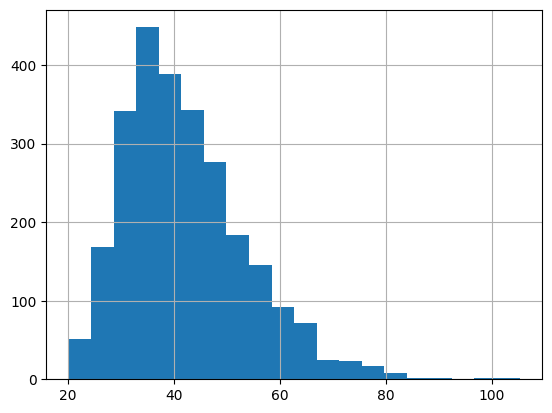

In [ ]:
model_df['METS_IR'].hist(bins=20)

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNRegressor
from tabpfn.constants import ModelVersion

X = model_df.drop(['METS_IR', 'METS_IR_CLASS'], axis=1)
y = model_df['METS_IR'].astype(float)  # Ensure target is float for regression

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the regressor
regressor = TabPFNRegressor()  # Uses TabPFN-2.5 weights, trained on synthetic data only.
# To use TabPFN v2:
# regressor = TabPFNRegressor.create_default_for_version(ModelVersion.V2)
regressor.fit(X_train, y_train)

# Predict on the test set
predictions = regressor.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print("Mean Squared Error (MSE):", rmse)
print("R² Score:", r2)

Mean Squared Error (MSE): 3.2649942699511945
R² Score: 0.9206449586921688


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

model = xgb.XGBRegressor(objective='reg:squarederror',
                          device='cuda',
                         tree_method='hist',  # Faster for your dataset size
    eval_metric='rmse',
                         n_estimators=100, random_state=42,colsample_bytree= 0.8, learning_rate= 0.1, max_depth= 3, subsample= 1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.3f}')
print(f'R²: {r2:.3f}')

RMSE: 3.288
R²: 0.920


In [ ]:

X_c = model_df.drop(['METS_IR', 'METS_IR_CLASS'], axis=1)
y_c = model_df['METS_IR_CLASS']  # Ensure target is float for regression

# Train-test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)


In [ ]:
model_df.groupby('METS_IR_CLASS').describe()['METS_IR']

,count,mean,std,min,25%,50%,75%,max
METS_IR_CLASS,,,,,,,,
0,769.0,30.300390,3.287847,20.083968,28.209107,30.807716,33.026992,34.991582
1,1819.0,47.092268,9.941938,35.009320,39.377500,44.748034,52.262569,105.236767


In [ ]:
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


model = xgb.XGBClassifier()

model.fit(X_train_c, y_train_c)

y_pred = model.predict(X_test_c)
# Evaluate the model
accuracy = accuracy_score(y_test_c, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
report = classification_report(y_test_c, y_pred)
print(report)
cm = confusion_matrix(y_test_c, y_pred)
print(cm)

Accuracy: 91.12%
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       151
           1       0.93      0.94      0.94       367

    accuracy                           0.91       518
   macro avg       0.89      0.89      0.89       518
weighted avg       0.91      0.91      0.91       518

[[127  24]
 [ 22 345]]


In [ ]:
clf = LogisticRegression(max_iter=10000, random_state=42)
clf.fit(X_train_c, y_train_c)


y_pred = clf.predict(X_test_c)
# Evaluate the model
accuracy = accuracy_score(y_test_c, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
report = classification_report(y_test_c, y_pred)
print(report)
cm = confusion_matrix(y_test_c, y_pred)
print(cm)

Accuracy: 91.70%
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       151
           1       0.94      0.94      0.94       367

    accuracy                           0.92       518
   macro avg       0.90      0.90      0.90       518
weighted avg       0.92      0.92      0.92       518

[[129  22]
 [ 21 346]]


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00


In [ ]:
import numpy as np

from catboost import CatBoostClassifier, Pool


model = CatBoostClassifier(iterations=30,
                           depth=3,
                           learning_rate=0.1,
                           loss_function='Logloss',
                           verbose=True,


                           )
# train the model
model.fit(X_train_c, y_train_c)
# make the prediction using the resulting model

y_pred = model.predict(X_test_c)
accuracy = accuracy_score(y_test_c, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
report = classification_report(y_test_c, y_pred)
print(report)
cm = confusion_matrix(y_test_c, y_pred)
print(cm)


0:	learn: 0.6251164	total: 549us	remaining: 15.9ms
1:	learn: 0.5672682	total: 1.23ms	remaining: 17.2ms
2:	learn: 0.5219199	total: 1.73ms	remaining: 15.6ms
3:	learn: 0.4802106	total: 2.21ms	remaining: 14.4ms
4:	learn: 0.4443893	total: 2.65ms	remaining: 13.2ms
5:	learn: 0.4137112	total: 3.08ms	remaining: 12.3ms
6:	learn: 0.3880634	total: 3.46ms	remaining: 11.4ms
7:	learn: 0.3647345	total: 3.87ms	remaining: 10.6ms
8:	learn: 0.3447331	total: 4.31ms	remaining: 10.1ms
9:	learn: 0.3271704	total: 4.77ms	remaining: 9.54ms
10:	learn: 0.3121347	total: 5.21ms	remaining: 9ms
11:	learn: 0.2976069	total: 5.67ms	remaining: 8.51ms
12:	learn: 0.2860841	total: 6.07ms	remaining: 7.93ms
13:	learn: 0.2748605	total: 6.46ms	remaining: 7.38ms
14:	learn: 0.2656730	total: 6.86ms	remaining: 6.86ms
15:	learn: 0.2570523	total: 7.24ms	remaining: 6.34ms
16:	learn: 0.2489213	total: 7.69ms	remaining: 5.88ms
17:	learn: 0.2411872	total: 8.12ms	remaining: 5.41ms
18:	learn: 0.2347317	total: 8.57ms	remaining: 4.96ms
19:	lea

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test_c, y_pred)
youden_index = tpr - fpr
best_threshold = thresholds[youden_index.argmax()]
print(f"Optimal threshold: {best_threshold}")


Optimal threshold: 1.0


In [ ]:
print("Original classification threshold:")
print(model.get_probability_threshold())
print("Predicted 1-st class probability:")
print(model.predict(X_train, prediction_type='Probability')[:, 1])
print("Predictions with 0.5 threshold:")
print(model.predict(X_train))
model.set_probability_threshold(0.275)
print("Predictions after setting 0.275 threshold:")
print(model.predict(X_train))


Original classification threshold:
0.5
Predicted 1-st class probability:
[0.96486664 0.94994952 0.94970636 ... 0.954664   0.9533967  0.9610616 ]
Predictions with 0.5 threshold:
[1 1 1 ... 1 1 1]
Predictions after setting 0.275 threshold:
[1 1 1 ... 1 1 1]
